<a href="https://colab.research.google.com/github/ManelSoengas/RT_BENE/blob/main/Trabajo_Deep_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real-Time Blink Estimation in Natural Environments**

---
##<font color='blue'> Classification problem  </font>

### **1. Import the libraries**

---


The first thing we are going to do is load the necessary modules from several libraries, including **Keras** (The Python Deep Learning library) and **Scikit-learn** (Machine learning in Python).


In [ ]:
# Load modules for libraries

import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf

from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Concatenate, Flatten,Conv2D, MaxPooling2D, Dropout
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import BinaryFocalCrossentropy
from matplotlib import pyplot as plt
from keras import backend as K


### **2. Prepare training data**


---


The** RT-BENE** data set is available, which contains images of eyes extracted from video frames in which a person is looking at the camera. From each of the frames, two images of the person in the plane are extracted: the image of the left eye and the image of the right eye.

The** RT-BENE.zip file** includes an images directory that contains all the images in the set with standard dimensions (60×36×3). A **blinks.csv** file is also included that defines, for each frame, whether it is a blink or not and the path to the images of the left and right eyes

Next, we will use **Scikit-learn's** **train_test_split method** to split the data into three partitions: **training, validation, and test**. In this example, we have used 70% of the images for training, 15% for validation and 15% for testing.

Finally, we will use the **ImageDataGenerator**() and **flow_from_dataframes**() methods to generate **batches** of images.

Several approaches are proposed to deal with the data set.

* Use of **weights**: use of the **class_weights argument**. We tell the model to “**pay more attention**” to samples from an underrepresented class.

* Add **Dropout layers**.

* Using a **custom loss function**. Focal_loss









In [ ]:
# Mount Google Drive in the project directory and unzip the file with the data
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/file/RT-BENE.zip' >> /dev/null

# Specify the paths to the directory that contains the images and to the file with the labels
data_path = 'RT-BENE/'
imgs_path = data_path + "images/"
labels_path = data_path + "blinks.csv"

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

# Upload the CSV file with the tags
labels = pd.read_csv(labels_path, dtype = {"blink": "category"})
labels.head()

# View the distribution of the Class
classes_zero = labels[labels['blink'] == '0']
classes_one = labels[labels['blink'] == '1']
print(f'Class 0: {len(classes_zero)}')
print(f'Class 1: {len(classes_one)}')

##Aumentar, con pocas muestras, la clase minoritaria. La cte numérica indica el % añadido
#classes_one = classes_one.sample(int(len(classes_zero)*0.1),replace=True)
print(f'Clase_0: {len(classes_zero)}')
print(f'Clase_1: {len(classes_one)}')
#labels= pd.concat([classes_zero, classes_one])
#labels = labels.sample(frac=1).reset_index(drop=True)

## Create data sets for train, test and validation
# train = 70%, validation = 15% and test = 15%
seed = 5
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Update indexes
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Normalization data (rescale)
datagen = ImageDataGenerator(rescale=1./255)

# We specify a series of parameters dependent on the data set
classes = ["0","1"]         # problem classes
n_classes = len(classes)    # classes number

# Definition of batch size and image
batch_size = 64              # batch size
img_width = 60
img_height = 36  # imagen size

## Function Generator
# Extracted the pair of eyes with their corresponding label.
def generator(dataframe):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe, directory = imgs_path, target_size = (img_width, img_height), x_col = left_eye_col, y_col = y_col, class_mode= "binary", seed = seed, batch_size = batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe, directory = imgs_path, target_size = (img_width,img_height), x_col = right_eye_col, y_col = y_col, class_mode="binary", seed = seed, batch_size = batch_size)

  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

# Generate batches
train_generator = generator(train_data)
dev_generator = generator(dev_data)
test_generator = generator(test_data)


## Assignación pesos_2
# Escalando el total/2 ayuda a mantener la pérdida a una magnitud similar.
# La suma de los pesos de todos los ejemplos permanece igual.

# Distribución de la Clase
classes_zero = labels[labels['blink'] == '0']
classes_one = labels[labels['blink'] == '1']

# Cálculo de los pesos
weight_for_0 = (1 / len(classes_zero)) * (len(labels) / 2.0)
weight_for_1 = (1 / len(classes_one)) * (len(labels) / 2.0)

# Creación clase y asignación pesos
class_weight = {0: weight_for_0, 1: weight_for_1}

# Visualización de los pesos
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))




Mounted at /content/gdrive
Class 0: 102793
Class 1: 4557
Clase_0: 102793
Clase_1: 4557
Weight for class 0: 0.52
Weight for class 1: 11.78


## **3. Definición de métricas**

---


Se definen las funciones para calcular las métricas ***recall*** y ***precisión*** que permitiran obtener el valor de*** F1_score***. Métrica utilizada para valorar el ***rendimiento*** en modelos con conjuntos de ***datos desequilibrados.***

***F1_Score*** = (2 * ***Precision*** * ***Recall***) / (***Precision*** + ***Recall***)


In [ ]:
## Definir algunas funciones para las métricas :
# Recall
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

# Precisión
def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

# F1_score
def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

## **4. Focal_Loss**

---



Definimos una ***función de pérdida*** customizada para tratar el conjunto de ***datos desequilibrados***. Sugerida en la literatura. El objetivo es dar al modelo algo más de ***libertad*** para correr algún riesgo a la hora de realizar predicciones. Esto es especialmente importante cuando se utiizan de conjuntos de datos muy desequilibrados. Cabe decir que es una modificación de la  función de pérdida ***entropía cruzada binaria***.
La función que la determina es :

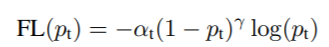


Donde :

***γ*** = pérdidas de los ejemplos bien clasificados.

***α*** = pesos para hacer frente al desequilibrio..



In [ ]:
# Se han seleccionado, para gamma y alpha, valores recomendados en diversas literaturas y ejemplos
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha*K.pow(1.-pt_1, gamma)*K.log(pt_1))-K.sum((1-alpha)*K.pow(pt_0, gamma)*K.log(1.-pt_0))
    return focal_loss_fixed

## **5. Creació de una red convolucional**




---



Se propoen crear una ***CNN*** y entrenarla desde cero. Al ***modelo*** le añadiremos unas ***capas convolucionales*** que nos permiten tratar problema de clasificación de clase binaria. Los parámetros del conjunto inicializarán aleatoriamente y se aprenderán durante el proceso de entrenamiento. Se utiliza ***Keras functional API*** que nos permite crear arquitecuras más flexibles añadiendo multiples entradas y/o salidas. El principio básico seguido para construir una ***CNN*** es "mantener el espacio de las características ancho y profundidad en las etapas iniciales de la red, y hacerlo más estrecho y profundo hacia el final.








In [ ]:
# Definición de las imágenes
input_shape = (60, 36, 3)

# Declaración de dos capas de Input y se concatenan
input_1 = Input(shape=input_shape)
input_2 = Input(shape=input_shape)
concate_input = Concatenate()([input_1, input_2])

##Adición de capas de convolución, de agrupación y connectadas.
# Los tamaños generales de los filtros que se utilizan son 3x3,
# para la capa convolucional para imágenes de tamaño moderado o pequeño
# y para los parámetros de Max-Pooling utilizamos tamaños de filtro de 2x2..
# Añadir dos capas convolucionales de 32 filtros (dimensiones 3x3), con ReLU como función de activación
x = Conv2D(32,3,activation ='relu')(concate_input)
x= Conv2D(32, 3, activation='relu')(x)

# Añadir una capa max-pooling con tamaño de ventana 2
x=MaxPooling2D()(x)
x=Dropout(0.25)(x)

# Añadir dos capas convolucionales de 64 filtros (dimensiones 3x3), con ReLU como función de activación
x=Conv2D(64, 3,activation='relu')(x)
x=Conv2D(64, 3,activation='relu')(x)

# Añadir una capa max-pooling con tamaño de ventana 2
x=MaxPooling2D()(x)
x=Dropout(0.25)(x)

## Añadir dos capas convolucionales de 128 y 64 filtros (dimensiones 3x3), con ReLU como función de activación
# Se utiliza el padding = same para ayudar a alargar su arquitectura de red,
# ya que el relleno mantiene las mismas dimensiones incluso después de la operación de convolución y,
# por tanto, se puede hacer más convoluciones sin reducir el tamaño.
x=Conv2D(128,3,padding='same',activation='relu')(x)
x=Conv2D(64,3,padding='same',activation='relu')(x)

# Añadir una capa max-pooling con tamaño de ventana 2
x=MaxPooling2D()(x)
x=Dropout(0.25)(x)

# Flatten permite transformar el volumen de entrada en un vector
x = Flatten()(x)

# Añadir una capa completamente conectada con 512 neuronas, con ReLU como función de activación
x= Dense(512, activation='relu')(x)
x=Dropout(0.75)(x)

# Añadir una última capa completamente conectada para obtener la salida de la red,
# utilizando para ello la función 'Sigmoid'.
predictions = Dense(1, activation='sigmoid')(x)

# Crear el modelo final.
model = Model(inputs = [input_1, input_2], outputs = predictions)

## Optimizadores y funciones de pérdida probados.
opt= optimizers.Adam(learning_rate=1e-4)
# opt = optimizers.SGD(learning_rate=1e-3, nesterov= True )
# loss = BinaryFocalCrossentropy(gamma=2.0)
# loss=[focal_loss(alpha=.25, gamma=2)]

# Antes de entrenar el modelo, se configura el proceso de aprendizaje
model.compile(loss=[focal_loss(alpha=.25, gamma=2)],  # función de pérdida, customizada, para problemas de clasificación binaria
              optimizer=opt, metrics=[f1_m, 'accuracy'])            # optimizador Adam

# Visualización de la representacion, en modo texto, del modelo
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 60, 36, 6)    0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 58, 34, 32)   1760        ['concatenate[0][0]']        

## **6. Arquitectura**

---



Visualización de la ***arquitectura*** diseñada.

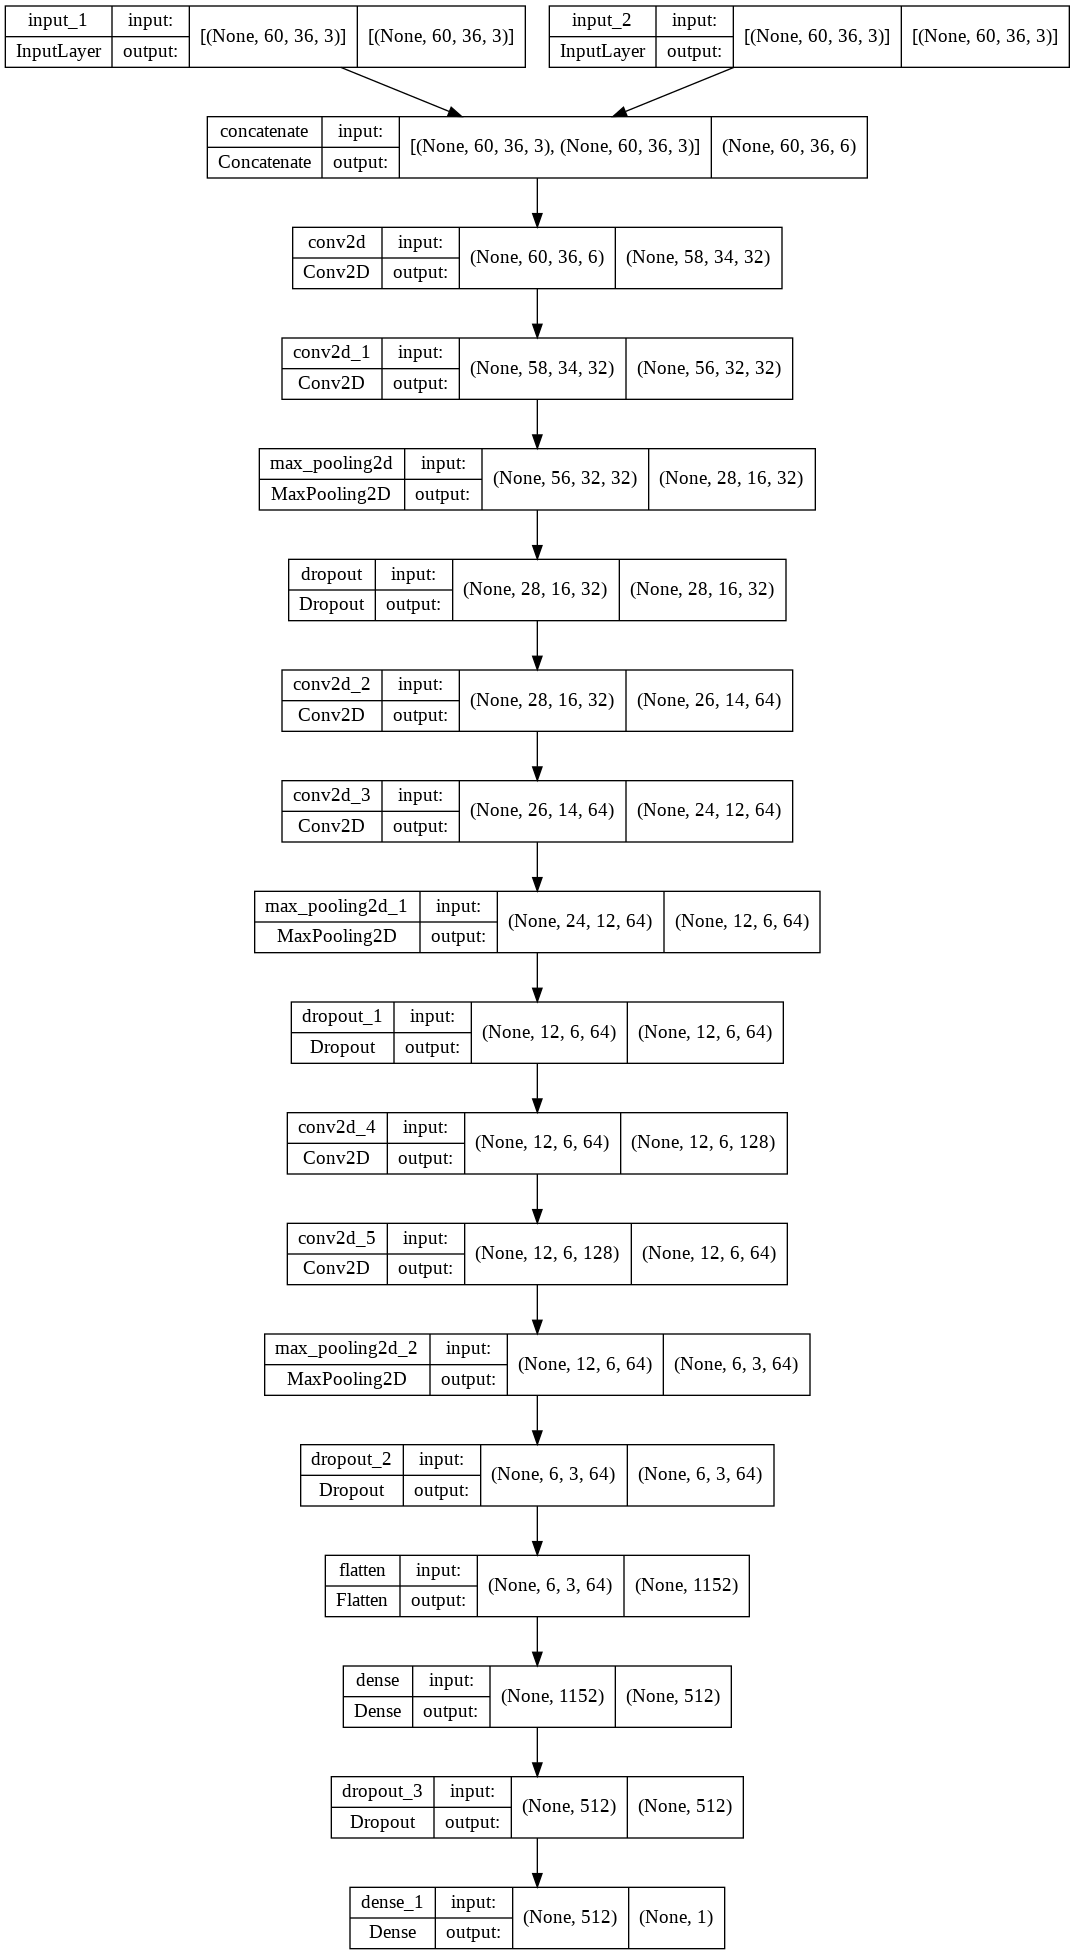

In [ ]:
plot_model(model, "my_first_model.png", show_shapes=True)

## **7. Entrenamiento del modelo**

---



Se entrena el ***modelo*** con los parámetros definidos. Se visualizan los resultados del entrenamiento mediante las ***métricas*** definidas. Donde ***epochs*** x [Datos/batch_size] = número de exposiciones del conjunto de datos.

In [ ]:
## Entrenamiento del modelo con los datos preparados.
# Configuración del proceso de entrenamiento :
# Número de epochs, Mostrar error al finalizar cada error (verbose =2),
history = model.fit(train_generator, epochs=15, verbose=2, steps_per_epoch=len(train_data)/batch_size, validation_data=dev_generator, validation_steps=len(dev_data)/batch_size, class_weight= class_weight)

# Evaluación del modelo en el conjunto de test
test_loss, f1_score, accuracy = model.evaluate(test_generator, steps=len(test_data)/batch_size, verbose=1)

print("A_test_loss: %.4f, A_f1_score: %.4f" % (test_loss, f1_score))

Found 75145 validated image filenames belonging to 2 classes.
Found 75145 validated image filenames belonging to 2 classes.
Epoch 1/15
Found 16102 validated image filenames belonging to 2 classes.
Found 16102 validated image filenames belonging to 2 classes.
1174/1174 - 77s - loss: 1.1151 - f1_m: 0.0057 - accuracy: 0.9563 - val_loss: 0.5646 - val_f1_m: 0.0453 - val_accuracy: 0.9580 - 77s/epoch - 65ms/step
Epoch 2/15
1174/1174 - 55s - loss: 0.6078 - f1_m: 0.2507 - accuracy: 0.9652 - val_loss: 0.4224 - val_f1_m: 0.5848 - val_accuracy: 0.9783 - 55s/epoch - 47ms/step
Epoch 3/15
1174/1174 - 54s - loss: 0.4133 - f1_m: 0.5306 - accuracy: 0.9765 - val_loss: 0.2502 - val_f1_m: 0.7108 - val_accuracy: 0.9866 - 54s/epoch - 46ms/step
Epoch 4/15
1174/1174 - 54s - loss: 0.3085 - f1_m: 0.6774 - accuracy: 0.9833 - val_loss: 0.1918 - val_f1_m: 0.8170 - val_accuracy: 0.9914 - 54s/epoch - 46ms/step
Epoch 5/15
1174/1174 - 54s - loss: 0.2497 - f1_m: 0.7388 - accuracy: 0.9869 - val_loss: 0.1538 - val_f1_m: 0

## **8. Gráficas**

---



Visualización de la evolución de ***F1_score***, ***loss*** y ***accuracy*** para los conjuntos de datos utilizados en el entrenamiento.

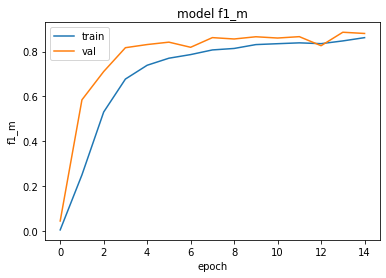

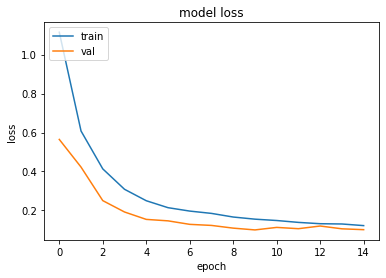

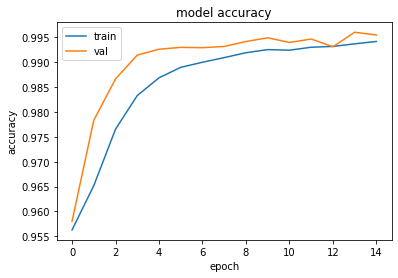

In [ ]:
## Gráficas de métricas en función de los epochs
# Gráfica de F1_score
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1_m')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Gráfica de loss (pérdida)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Gráfica d eaccuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## **9. Recursos**

A continuación se citan algunos de los ***recursos*** utilizados para la realización del trabajo.

---



**Métricas :**

https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec

**Focal loss :**

https://towardsdatascience.com/a-loss-function-suitable-for-class-imbalanced-data-focal-loss-af1702d75d75

**Datos desequilibrados, weight :**

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://developpaper.com/using-class-weight-to-improve-class-imbalance/

**Libro : Python Deep Learning**

Autor, Jordi Torres

**Gráficos :**

https://matplotlib.org/stable/tutorials/introductory/pyplot.html

**Materiales de la asignatura**.